In [1]:
from __future__ import division
from __future__ import print_function 
import numpy as np
import pandas as pd
from collections import OrderedDict
import argparse
import re
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
pd.DataFrame.melt?

In [80]:
########################################
## FUNCTIONS
def load_posteriors( f_posteriors, cols_rename = {".alpha1" : "post_alpha" , ".beta1" : "post_beta",
                                                   ".fitted": "post_mean", ".raw" : "freq_mle" },
                   drop_zeroCoverage = True ):
    """
    Inputs
    ------
        f_posteriors - OrderedDict keys are conditions values are file names
        cols_rename - dictionary keys are columns of files to load values and new names for the loaded columns
        drop_zeroCoverage  - bool
    Returns:
    -------
        df_post - dataframe
    """
    df_list = []
    for c, f in f_posteriors.items():
        print("\tloading file {} for condition {}".format(f,c))
        df = pd.read_csv(f, sep = "\t", header = 0, index_col = [0,1], usecols = ["seq" , "idx"] + list(cols_rename.keys()) )
        df = df.rename(columns = cols_rename)
        df_list.append(df)
    df_post = pd.concat(df_list , keys =  f_posteriors.keys() , axis = 1)
    if drop_zeroCoverage:
        print("\tRemoving CpG C\'s not covered in >= 1 condition")
        print( "\tn not covered by conition")
        print(df_post.isna().sum(axis=0).groupby(level = 0).apply(lambda x: x.iloc[0]))
        no_coverage = df_post.isna().any(axis = 1)
        print("\ttotal not covered {}".format(no_coverage.sum() ) )
        df_post = df_post.loc[~ no_coverage ,: ].copy()
        print("\ttotal remaining covered {}".format(df_post.shape[0]) )            
    return df_post

def load_priors(f_priors):
    """
    Input:
    ------
        f_posteriors - OrderedDict keys are conditions values are file names
    """
    df_pri = pd.DataFrame( np.zeros( (2,len(f_priors)), dtype = float),
                          index = ["alpha" , "beta"]  , 
                          columns = list(f_priors.keys())  ) 
    for c, fname in f_priors.items():
        f = open(fname,'r')
        lines = f.readlines()
        f.close()
        alpha = [ re.search( 'alpha\s+([\d|\.]+)', x).group(1) for x in lines if  re.search( 'alpha\s([\d|\.]+)', x) is not None ]
        if len(alpha) >1:
            raise Exception("found more than one match for alpha")
        else:
            df_pri.loc["alpha" , c] = float(alpha[0])
        
        beta = [ re.search( 'beta\s+([\d|\.]+)', x).group(1) for x in lines if re.search( 'beta\s+([\d|\.]+)', x) is not None ]
        if len(beta) >1:
            raise Exception("found more than one match for beta")
        else:
            df_pri.loc["beta" , c] = float(beta[0])
    betaMean = df_pri.loc["alpha", :].divide( df_pri.loc["alpha", :] +  df_pri.loc["beta", :] )
    betaMean.name = "prior_mean"
    df_pri =pd.concat([df_pri, betaMean.to_frame().transpose()], axis =0)  ## hack
    return df_pri


####################################################
## Plotting 
def plot_conditionDiffs(plotData,  kwargs_hist= {"bins" : 30,  "log": True , "histtype" : 'step' } ):
    """
    
    """
    plotData = plotData.reset_index(drop = True).melt( value_name='difference in\n mCpGs relative\nto prior')
    plotData["condition1"] = plotData["variable"].apply(lambda x: x.split("_")[0])
    plotData["condition2"] = plotData["variable"].apply(lambda x: x.split("_")[-1])
    plotData = plotData.drop(columns = "variable")
    g = sns.FacetGrid(plotData, col="condition2",  row="condition1", margin_titles = True)
    g = g.map(plt.hist, 'difference in\n mCpGs relative\nto prior' , **kwargs_hist)

    g.fig.tight_layout()
    return g

def plot_conditionDiffs_singleRow(plotData, conditions,  bins = np.linspace(-1., 1., 100), fig_width = 14,
                                  ax_height = 4, colors = plt.cm.tab10.colors, xlabel = "difference in mCpGs relativeto prior",
                                 kwargs_hist = {"log" : True, "histtype" : 'step'} ):

    nrows = len(conditions)
    ncols = 1
    fig , axes = plt.subplots(nrows =  nrows, ncols = 1 , figsize = (fig_width , ax_height*nrows))
    conditions_to_colors = {c : color for c, color in zip(conditions, colors) }


    for c1, ax in zip(conditions , axes):
        conditions_minus_c1 = [x for x in conditions if x!= c1 ]
        for c2 in conditions_minus_c1:
            ## find column
            plotCol = [ x for x in plotData.columns if  (c1 in x.split("_")) and  (c2 in x.split("_")) ]
            assert len(plotCol) ==1 , "multiple matches found for conditions {}, {}".format(c1,c2)
            plotCol = plotCol[0]
            ## check sign of differences between conditions
            if  (plotCol.split("_")[0] == c1) and (plotCol.split("_")[-1] == c2 ):
                ax.hist(plotData.loc[: , plotCol ].values, bins = bins, label =c2, color = conditions_to_colors[c2], **kwargs_hist)
            elif (plotCol.split("_")[0] == c2) and (plotCol.split("_")[-1] == c1 ):
                ax.hist( -1*plotData.loc[: , plotCol ].values, bins = bins, label= c2, color = conditions_to_colors[c2], **kwargs_hist)
            else:
                raise Exception("problem")
        ax.set_title(c1)
        ax.set_xlabel(xlabel)
        ax.legend(loc = 1, bbox_to_anchor = (1.2, 1.), title = "condition_subracted", title_fontsize = 14 )
    fig.tight_layout()
    return fig

def plot_conditionDiffs_OLD(plotData, conditions, fig_width= 20, ax_height=4, bins=100 ,
                            xlabel = "difference in\n mCpGs relative\nto prior"):
    """
    Input:
        plotData - columns are <conditionName1>_minus_<conditionName2>  ...
        conditions - list of conditions used to generate plotData **these must be in a specific order (code is messy ..)
        
    
    """
    nrows = len(conditions)
    ncols = len(conditions)

    figsize =( fig_width , nrows * ax_height)
    fig , axes = plt.subplots(figsize = figsize , nrows = nrows, ncols = ncols)

    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i,j]
            if j > i:
                plotData = plotDF.loc[: ,"{}_minus_{}".format(conditions[i] , conditions[j] )]
                sns.kdeplot(plotData.values, ax = ax, shade =True)
                ax.set_yscale("log")
                if  ax.is_first_row():
                     ax.set_title( conditions[j] ) 
                if j -1 == i:
                    ax.set_ylabel(conditions[i])
                    ax.set_xlabel(xlabel)
            else:
                 ax.set_visible(False)
        #break
    fig.tight_layout()
    return fig

In [3]:
########################################
## Parse CMD line

parser= argparse.ArgumentParser(description= "Rank CpGs by variability of methylation between pairs of conditions")
parser.add_argument("-c", "--conditions", help = "comma separated list of condition names")
parser.add_argument("--f_prior" , help = "comma separated list with prior parameters")
parser.add_argument("--f_posterior" , help = "comma separated list of file names, columns must include XX,XX ...")
parser.add_argument("-o" , "--fo" , help = "basename for outputs")

exampleArgs = "-c 3A1,3A2,3B1,3A13L,3A23L,3B13L-d1 \
--f_prior dME_bayes_eBB_3A1.prior.txt,dME_bayes_eBB_3A2.prior.txt,\
dME_bayes_eBB_3B1.prior.txt,dME_bayes_eBB_3A13L.prior.txt,\
dME_bayes_eBB_3A23L.prior.txt,dME_bayes_eBB_3B13L-d1.prior.txt \
--f_posterior dME_bayes_eBB_3A1.posterior.tsv,dME_bayes_eBB_3A2.posterior.tsv,\
dME_bayes_eBB_3B1.posterior.tsv,dME_bayes_eBB_3A13L.posterior.tsv,\
dME_bayes_eBB_3A23L.posterior.tsv,dME_bayes_eBB_3B13L-d1.posterior.tsv \
-o test"
args = parser.parse_args(exampleArgs.split())
conditions = args.conditions.split(",")
f_prior = OrderedDict([(c,  x) for c , x in zip(conditions, args.f_prior.split(",") )])  
f_posterior = OrderedDict([(c , x) for c , x in zip(conditions, args.f_posterior.split(",") )])  

In [4]:
df_post = load_posteriors(f_posterior)
df_pri = load_priors(f_prior)

	loading file dME_bayes_eBB_3A1.posterior.tsv for condition 3A1
	loading file dME_bayes_eBB_3A2.posterior.tsv for condition 3A2
	loading file dME_bayes_eBB_3B1.posterior.tsv for condition 3B1
	loading file dME_bayes_eBB_3A13L.posterior.tsv for condition 3A13L
	loading file dME_bayes_eBB_3A23L.posterior.tsv for condition 3A23L
	loading file dME_bayes_eBB_3B13L-d1.posterior.tsv for condition 3B13L-d1
	Removing CpG C's not covered in >= 1 condition
	n not covered by conition
3A1         1269
3A13L       1899
3A2          783
3A23L       1111
3B1          777
3B13L-d1    1725
dtype: int64
	total not covered 3569
	total remaining covered 519693


In [5]:
## Compute differnce betwen posterior_mean and prior_mean
y = df_post.groupby(axis=1, level = 0).apply( lambda x: x.loc[: ,(x.name , "post_mean")] - df_pri.loc["prior_mean", x.name] )
y.columns =  pd.MultiIndex.from_tuples( [(c , "local_diff") for c in list(y.columns)] )
df_post = df_post.join(y).sort_index(axis = 1 ,level=0 )

In [6]:
## Compute skew
conditionDiffs = pd.DataFrame( np.zeros( shape= (df_post.shape[0], (len(conditions)*(len(conditions) -1))//2) , dtype = float),
                             index = df_post.index,
                             columns = list(combinations(conditions,2)))

for pair in combinations(conditions,2):
    conditionDiffs.loc[: , pair] = df_post.loc[: , (pair[0],"local_diff")] -  df_post.loc[: , (pair[1],"local_diff")] 

conditionDiffs = conditionDiffs.rename(columns = lambda x: "{}_minus_{}".format(x[0] , x[1]) )

In [48]:
conditionDiffs.to_csv( "./ConditionsDifferences_relativeME.tsv" , sep = "\t" , float_format= '%.6f' )

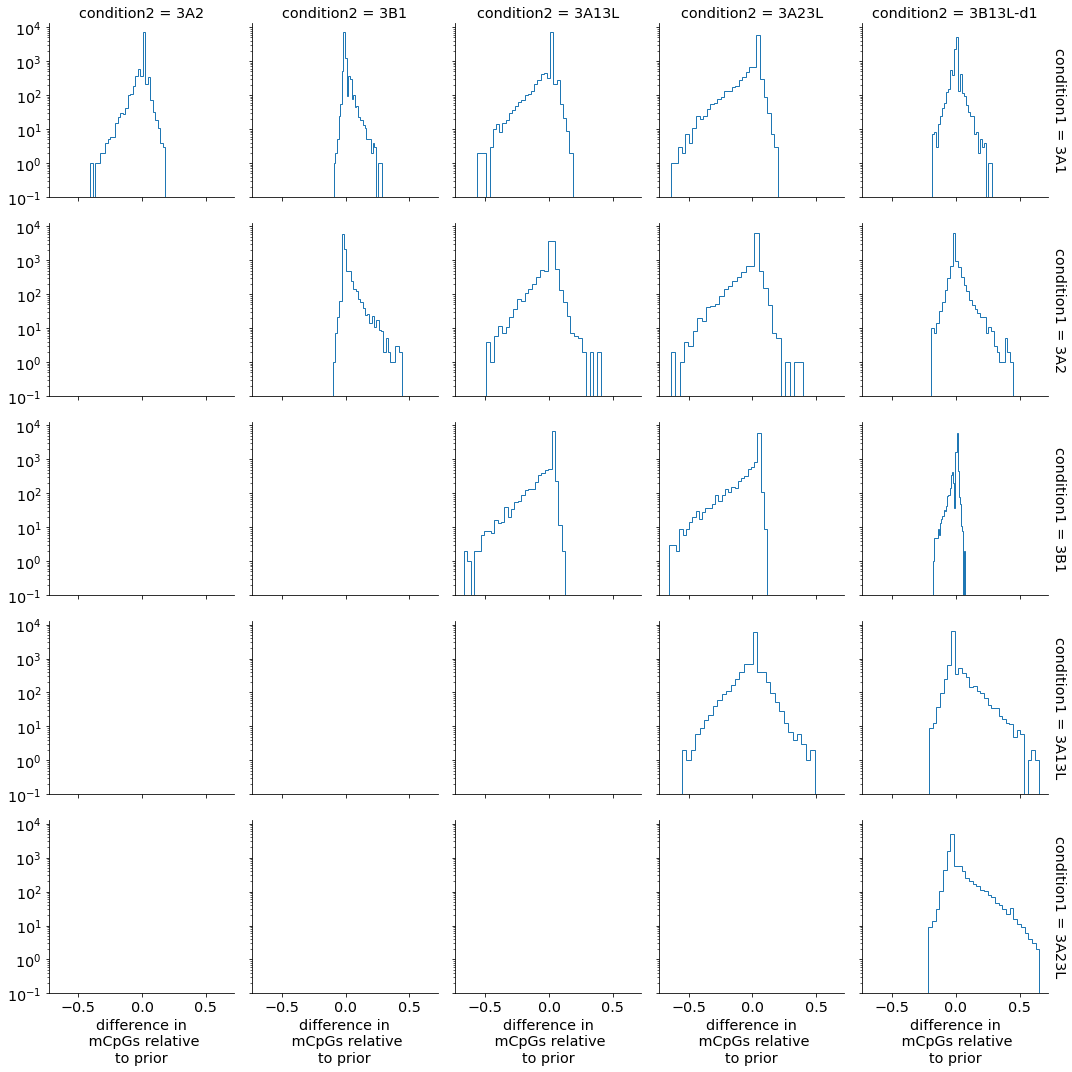

In [79]:
plotData = conditionDiffs.sample(n = 10000)
g = plot_conditionDiffs(plotData,  kwargs_hist= {"bins" : 30,  "log": True , "histtype" : 'step' } )
g.savefig("./ConditionsDifferences_relativeME_gridplot.png")

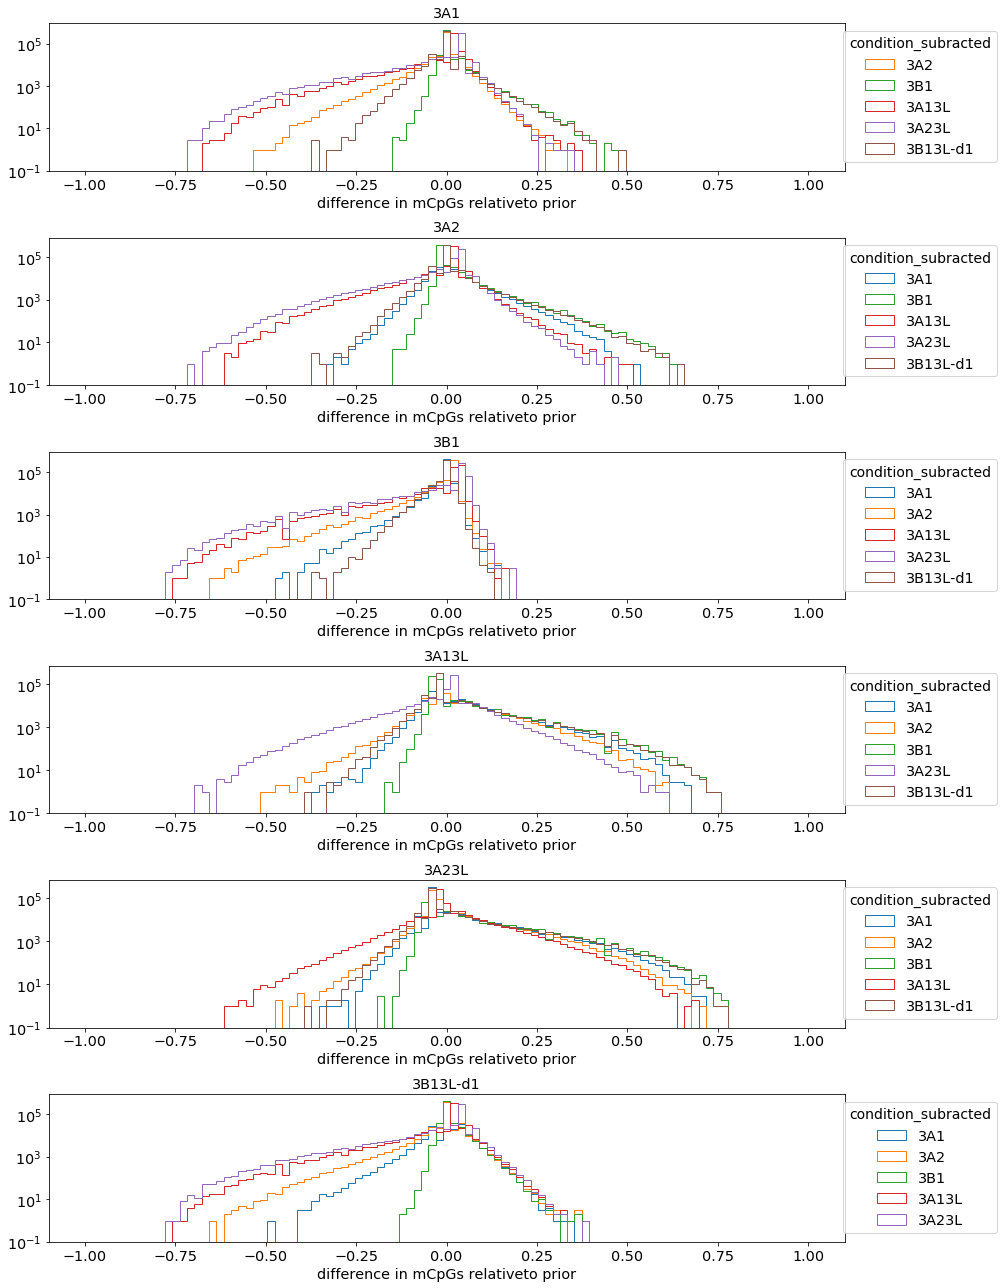

In [85]:
#conditions =conditions
ax_height = 3
plotData = conditionDiffs.copy()
fig =  plot_conditionDiffs_singleRow(plotData= plotData , conditions = conditions, ax_height = ax_height)
g.savefig("./ConditionsDifferences_relativeME_singleRow.png", bbox_inches = "tight")

## TODO: cluster by differences between posterior and prior mean methylation rate

## Below is scratch

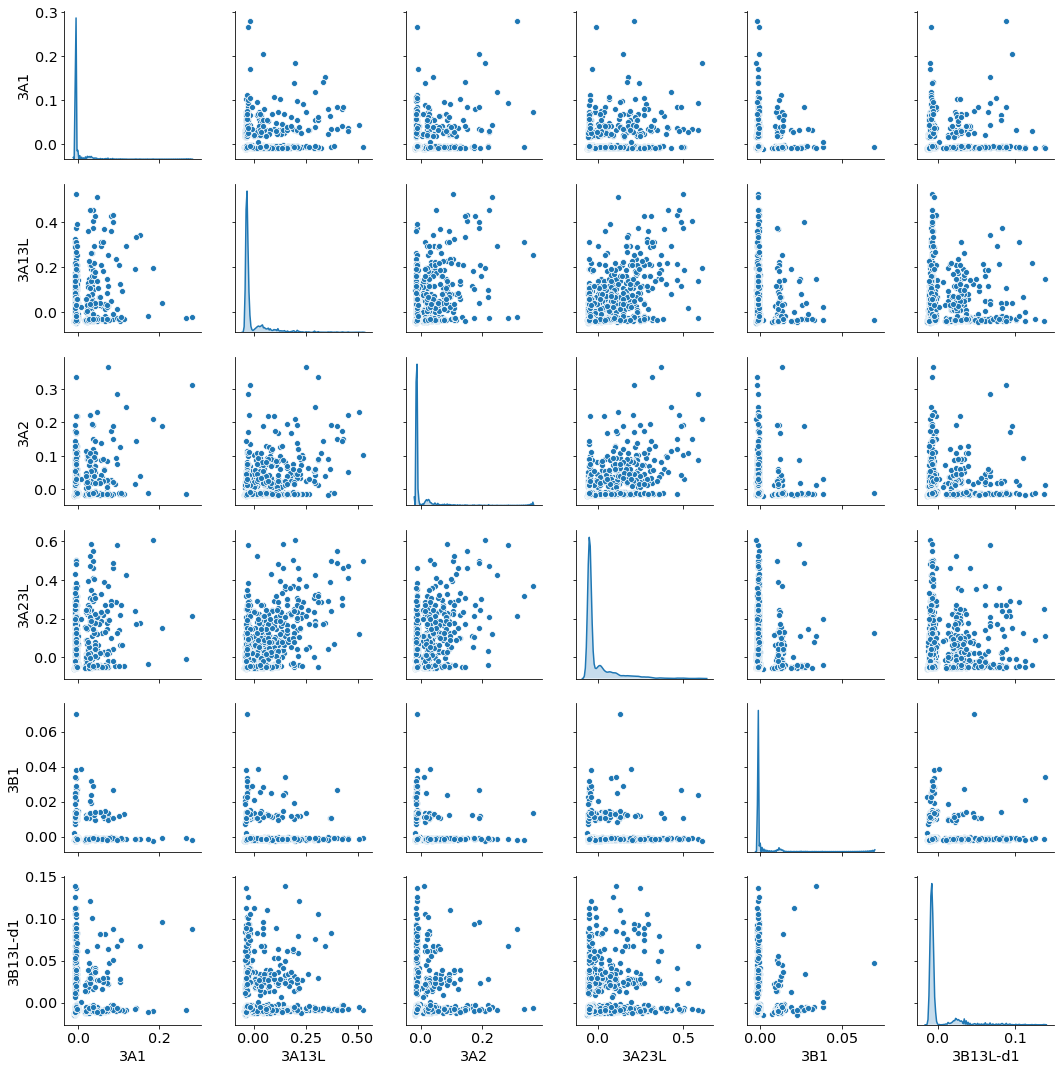

In [17]:
g = sns.pairplot(df_post.loc[: , (slice(None) , "local_diff")].droplevel(axis = 1 , level = 1).reset_index(drop= True).sample(n = 2000),
                kind = "scatter", diag_kind = "kde")
g.savefig("pairPlot_posteriorMean.minus.PriorMean_sample2000.png")

## Below is scratch

In [9]:
sns.pairplot?

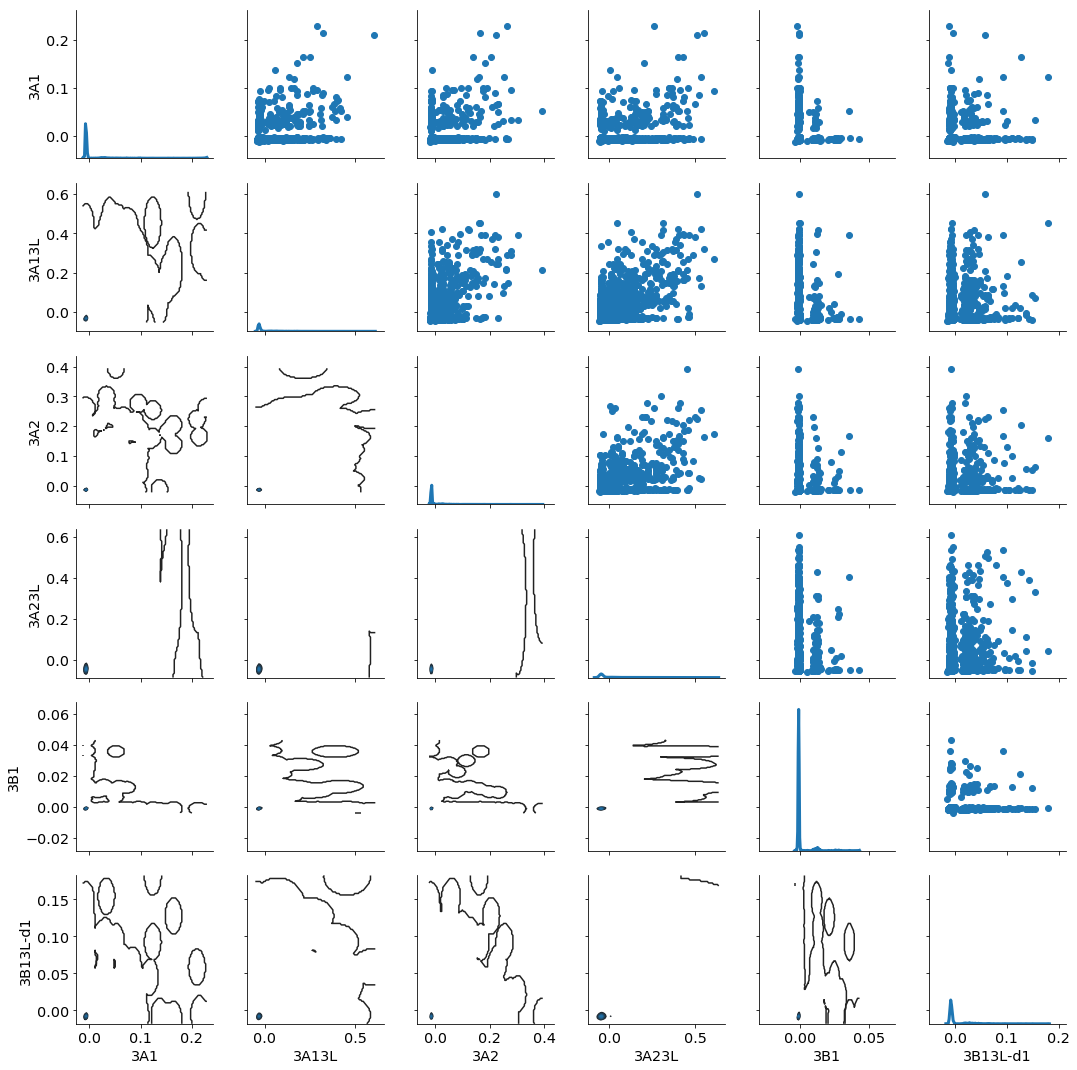

In [15]:
plotDF = df_post.loc[: , (slice(None) , "local_diff")].droplevel(axis = 1 , level = 1).reset_index(drop= True).sample(n = 2000)
g = sns.PairGrid( plotDF  )
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);